**Indiquer dans la boîte ci-dessous vos noms et prénoms**

Monome : Baaloudj Hakim

# 3I026 - Intelligence artificielle & Data science

## TP 2 - k-plus proches voisins (*k-NN*)

Dans ce TP, nous allons principalement mettre en place une "architecture" de code nous permettant petit à petit de tester différents modèles d'apprentissage supervisé et programmer les k-NN. Nous allons nous restreindre au cas binaire où les données sont étiquetées $+1$ ou $-1$.

In [85]:
import numpy as np
import pandas as pd
from math import sqrt

**Remarque** La concaténation de vecteurs s'obtient à l'aide de la fonction `vstack` de numpy.

### Étape 1: dataset

La première étape consiste à définir une classe permettant de stocker les données d'apprentissage, de validation et de test. Nous considérerons que les données tiennent en mémoire. Nous allons définir une classe permettant de stocker des couples $\{(x_1,y_1),...,(x_n,y_n)\}$. Les $x_i$ et $y_i$ seront des tableaux numpy.

In [3]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
    
    def getSizeX(self):
        return len(self.x)
    
    #Renvoie la valeur de y_i
    def getY(self, i):
        return(self.y[i])
    
    #renvoie les indices des points d'une classe donnée
    def get_by_label(self, label):
        return np.where(self.y == label)[0]

#### Génération de données ''Jouet''

Nous allons pour l'instant nous intéresser à des datasets "jouet" générés selon des distributions choisies à la main. Commençons par un dataset en 2 dimensions (entrée) et 1 dimension (sortie): $x_i \in \mathbb{R}^2$, $y_i \in \{-1;+1\}$ tel que les données sont générées selon deux gaussiennes. Pour cela, nous utiliserons la fonction `numpy.random.multivariate_normal` - http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html

- `positive_center` est le centre de la gaussienne des points positifs (vecteur de taille 2)
- `positive_sigma` est la variance de la gaussienne (sous forme de matrice 2*2)
- Idem pour `negative`

Générer une premiere gaussienne associée au label $+1$.

Y ajouter une seconde gaussienne associée au label $-1$.

In [184]:
import matplotlib.pyplot as plt

print("+1 : blue circle\n-1 : red cross")

mean = [3, 7]      
cov = [[1,0],[0,5]] 
Posit = np.random.multivariate_normal(mean,cov,100)

mean = [-2, 5]    
cov = [[3,0],[0,5]] 
Negat = np.random.multivariate_normal(mean,cov,100)



+1 : blue circle
-1 : red cross


Le data set peut être affiché en utilisant matplotlib (pour vérifier) et plus précisément la fonction `matplotlib.pyplot.scatter` permettant de dessiner un nuage de points - http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter -

In [13]:
import matplotlib.pyplot as plt
# Permet d'afficher les figures directement dans le notebook:
%matplotlib inline

def plot2DSet(dataset):
    plt.scatter(dataset.x[0:int(dataset.size()/2),0],dataset.x[0:int(dataset.size()/2),1],marker='o')
    plt.scatter(dataset.x[int(dataset.size()/2):dataset.size(),0],dataset.x[int(dataset.size()/2):dataset.size(),1],marker='x')

In [5]:
import matplotlib.pyplot as plt
# Permet d'afficher les figures directement dans le notebook:
%matplotlib inline

def plot2DSet(dataset):
    def plot(xy, marker):
        plt.scatter(xy[:,0], xy[:,1], marker = marker)
    assert dataset.getInputDimension() == 2
    plot(dataset.x[dataset.get_by_label(1)], 'o')
    plot(dataset.x[dataset.get_by_label(-1)], 'x')

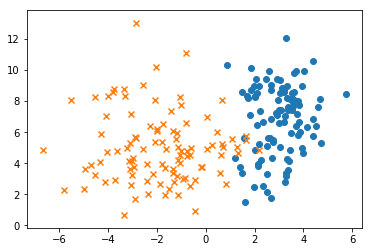

In [185]:
my_set = LabeledSet(2)
for p in Posit:
    my_set.addExample(p,+1)
for n in Negat:
    my_set.addExample(n,-1)


plot2DSet(my_set)

### Étape 2: les classifieurs

Un classifieur (binaire) permet, pour chaque point d'entrée, de calculer un score. Si le score est négatif, la donnée est associée à la classe $-1$, sinon à la classe $+1$. Commençons par définir une classe permettant par la suite de définir plusieurs classifieurs.

Pour l'instant les méthodes `train` et `predict` ne seront pas définies car elles dépendent du modèle.

La fonction `computeAccuracy` renvoie le pourcentage de points bien classés. Elle peut être définie dès maintenant.



In [7]:
class Classifier:
    def __init__(self, input_dimension):
        #raise NotImplementedError("Please Implement this method")
        self.input_dimension = input_dimension
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        raise NotImplementedError("Please Implement this method")


    #Permet d'entrainer le modele sur un ensemble de données
    def train(self, labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        accu = 0
        for i in range(dataset.getSizeX()):
            if(self.predict(dataset.getX(i)) == dataset.getY(i)):
                accu+=1
        return (accu/dataset.getSizeX())

Nous allons maintenant définir un classifieur linéaire aléatoire :
- la fonction `predict` renvoie la valeur de $\langle x | w\rangle$ où $w$ est un vecteur (de taille `input_dimension`) tiré aléatoirement à la construction du classifieur.


In [42]:
class ClassifierRandom(Classifier):
    def __init__(self,input_dimension):
        super(ClassifierRandom,self).__init__(input_dimension)
        self.w = np.random.uniform(-5, 5, (1,input_dimension))[0]
    def predict(self,x):
        return np.random.choice([-1, 1])

l = ClassifierRandom(2)
l.predict(my_set.getX(150))

1

Nous allons calculer la performance (*accuracy*) du classifieur random sur un ensemble de 100 points

In [56]:
set_test_accuracy = LabeledSet(2)
classif_rand = ClassifierRandom(2)

mean = [5, 6]      
cov = [[1,0],[0,5]] 
Posit = np.random.multivariate_normal(mean,cov,50)
    
mean = [-1, -10]
cov = [[1,0],[0,5]] 
Negat = np.random.multivariate_normal(mean,cov,50)

for p in Posit:
    set_test_accuracy.addExample(p,+1)
for n in Negat:
    set_test_accuracy.addExample(n,-1)
    
print(classif_rand.accuracy(set_test_accuracy))

0.56


Voici une fonction qui permet de dessiner la frontière de decision d'un classifieur. La valeur `step` permet de choisir la précision du dessin.

In [57]:
def plot_frontiere(set, classifier, step=20):
    mmax = set.x.max(0)
    mmin = set.x.min(0)
    x1grid, x2grid = np.meshgrid(np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step))
    grid = np.hstack((x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1)))
    
    # calcul de la prediction pour chaque point de la grille
    res = np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res = res.reshape(x1grid.shape)
    # tracé des frontieres
    plt.contourf(x1grid, x2grid, res, colors=["red", "cyan"], levels=[-1000,0,1000], linewidth=2)

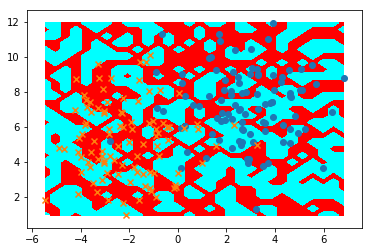

In [126]:
classifieur_random=ClassifierRandom(2)



the_set = my_set
plot_frontiere(the_set,classifieur_random, step=30)
plot2DSet(the_set)

### Étape 3 : k-NN

L'objectif est de définir le classifieur k-NN. Pour cela nous allons construire un tableau de distances que nous trierons grâce à la méthode `numpy.argsort`.

In [92]:
class KNN(Classifier):
    def __init__(self,input_dimension,k):
        super(KNN,self).__init__(input_dimension)
        self.k = k
        self.dataset = LabeledSet(input_dimension)
    def train(self,LabeledSet):
        self.dataset = LabeledSet
    
    def distanceEucli(self,vec1,vec2):
        dist = 0
        for i in range(self.input_dimension):
            dist += pow((vec2[i]-vec1[i]),2)
        return sqrt(dist)
    
    def predict(self,x):
        all_dist = [0]*self.dataset.getSizeX()
        for i in range(self.dataset.getSizeX()):
            all_dist[i] = self.distanceEucli(x,self.dataset.getX(i))
        index_sorted = np.argsort(all_dist)
        score = 0
        for i in range(self.k):
            score += self.dataset.getY(index_sorted[i])
        if(score < 0):
            return -1
        return 1
        
       
        

0.975


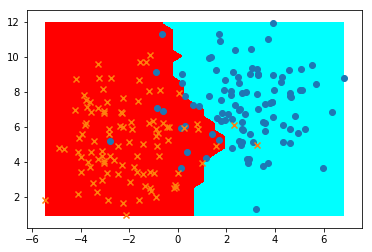

In [186]:
knn = KNN(2,7) #(dimension,k)
knn.train(my_set)
plot_frontiere(the_set,knn,30)
plot2DSet(the_set)

print(knn.accuracy(my_set))

### Étape 4: protocole expérimental

Attention, lorsque vous testez un classifieur, il est nécessaire de considérer à la fois un ensemble d'apprentissage et un ensemble de test. La performance doit être évaluée sur l'ensemble de test (et non pas sur l'ensemble d'apprentissage).

In [187]:
def sample(liste,x): #fonction qui va me découper mon ensemble en 2 partie, suivant le % 'x'
    listA = []
    listB = []
    firstHalf = int(len(liste)*(x/100))
    secondHalf = len(liste) - firstHalf
    for i in range(firstHalf):
        listA.append(liste[i])
    for j in range(secondHalf):
        listB.append(liste[j])
    return listA,listB

posit_train, posit_test = sample(Posit,70) #l'ensemble de data train contient 70% du set de base, celui de test contient donc 30%
negat_train, negat_test = sample(Negat,70)

datatrain = LabeledSet(2)
for i in posit_train:
    datatrain.addExample(i,+1)
for i in negat_train:
    datatrain.addExample(i,-1)
    
datatest = LabeledSet(2)
for i in posit_test:
    datatest.addExample(i,+1)
for i in negat_test:
    datatest.addExample(i,-1)

    



#### Travail libre

Comparer la performance (en train et test) de plusieurs classifieurs KNN avec différentes valeurs de k. Que pouvez vous constater ?
Idéalement, vous tracerez la performance (accuracy) en fonction de la valeur de k.
Essayez avec différentes configurations de gaussiennes.

0.95
-1


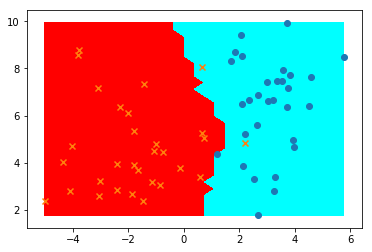

In [196]:
knn2 = KNN(2,7)
knn2.train(datatrain)
plot_frontiere(datatest,knn2,30)
plot2DSet(datatest)
print(knn2.accuracy(datatest))

print(knn2.predict([0.2,4.0]))

#On peut voir sur plus k est petit, plus la performance est elevé car on est dans un cas de sur apprentissage (apprentissage par coeur)
#il est donc très performant sur un ensemble de donnée qu'il connait très bien
#quand k est trop grand, on est dans un cas de sous apprentissage

### Étape 5 : données réelles UCI

Plusieurs datasets sont téléchargeables depuis: http://mldata.org

Voici la fonction permettant de les charger (en spécifiant leur nom). La fonction se charge de charger les données depuis le web.

In [13]:
from sklearn.datasets import fetch_mldata

def loadFile(name):
    data = fetch_mldata(name, data_home='.')
    print(data.data.shape)
    unique=np.unique(data.target)
    for i in range(len(data.target)):
        if (data.target[i]==unique[0]):
            data.target[i]=1
        else:
            data.target[i]=-1
            
loadFile('breast-cancer_scale')
#Les donnees sont dans data.data et data.target

(683, 10)


Écrire la fonction de split permettant de découper les données en un ensemble d'apprentissage et un ensemble de test.

Tester différents k-NN , pour différents k, et tracer la courbe de performance (accuracy) pour les données d'apprentissage et les données de test.